In [1]:
from ema_workbench import Model, MultiprocessingEvaluator, Policy, Scenario

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import pairs_plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ema_workbench.analysis import prim

from ema_workbench.analysis import feature_scoring

In [2]:
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(4)

    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        results = evaluator.perform_experiments(scenarios=100, policies=3)

100%|████████████████████████████████████████| 300/300 [00:13<00:00, 22.85it/s]


In [5]:
#Policies provincie Gelderland


def get_do_nothing_dict():
    return {l.name: 0 for l in model.levers}


policies = [
    #Policy 1 - maximize protection of urban and economic infrastucture
    #Avoid room for the river: no land use change or public resistance
    #Minimal reliance on early warning system
    #conflict Veluwe- prioritizing safety over sustainability and biodiversity
    Policy("maximum_defense_policy",**dict(
            get_do_nothing_dict(),
            **  {
    "1_RfR 0": 0, "2_RfR 0": 0, "3_RfR 0": 0, "4_RfR 0": 0, "5_RfR 0": 0,
    "Deventer_DikeIncrease 0": 10,
    "Zutphen_DikeIncrease 0": 10,
    "EWS_DaysToThreat": 1
})),
    #Policy 2 - Full endorsement of Room for the River to increase IJssel discharge capacity
    #Moderate dike heightening to supplement nature-based protection
    #Standard early warning window
    #Conflict Veluwe - RfR used primarily for discharge acceleration, not retention & Less focus on groundwater or drought resilience
    Policy("flow_through_strategy", **dict(
            get_do_nothing_dict(),
            **{
    "1_RfR 0": 1, "2_RfR 0": 1, "3_RfR 0": 1, "4_RfR 0": 1, "5_RfR 0": 1,
    "Deventer_DikeIncrease 0": 5,
    "Zutphen_DikeIncrease 0": 5,
    "EWS_DaysToThreat": 2
})),
    #Policy 3
    #Focus on cost-efficiency and public acceptability
    #Selective RfR implementation — only where socially feasible (e.g., farmland)
    #Mid-level dike upgrades as a political compromise
    #Conflict Veluwe - Weak commitment to groundwater recharge or ecosystem restoration
    Policy("balanced_cost_safety", **dict(
            get_do_nothing_dict(),
            **{
    "1_RfR 0": 0, "2_RfR 0": 1, "3_RfR 0": 0, "4_RfR 0": 1, "5_RfR 0": 1,
    "Deventer_DikeIncrease 0": 7,
    "Zutphen_DikeIncrease 0": 3,
    "EWS_DaysToThreat": 3
}))
]



In [6]:
n_scenarios = 100
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

100%|████████████████████████████████████████| 300/300 [00:13<00:00, 21.47it/s]


In [7]:
experiments, outcomes = results

df = pd.DataFrame(experiments)

#Add damage per experiment
df["damage_t0"] = outcomes["Expected Annual Damage"][:, 0]
df["damage_t1"] = outcomes["Expected Annual Damage"][:, 1]
df["damage_t2"] = outcomes["Expected Annual Damage"][:, 2]

#Add deaths per experiment
df["deaths_t0"] = outcomes["Expected Number of Deaths"][:, 0]
df["deaths_t1"] = outcomes["Expected Number of Deaths"][:, 1]
df["deaths_t2"] = outcomes["Expected Number of Deaths"][:, 2]

#Add costs per experiment
df["evac_costs_t0"] = outcomes["Expected Evacuation Costs"][:,0]
df["evac_costs_t1"] = outcomes["Expected Evacuation Costs"][:, 1]
df["evac_costs_t2"] = outcomes["Expected Evacuation Costs"][:, 2]
df["rfr_costs_t0"] = outcomes["RfR Total Costs"][:,0]
df["rfr_costs_t1"] = outcomes["RfR Total Costs"][:, 1]
df["rfr_costs_t2"] = outcomes["RfR Total Costs"][:, 2]

df.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,damage_t2,deaths_t0,deaths_t1,deaths_t2,evac_costs_t0,evac_costs_t1,evac_costs_t2,rfr_costs_t0,rfr_costs_t1,rfr_costs_t2
0,127,197.661728,1.5,0.101751,263.596530,10.0,0.458950,211.346429,10.0,0.518126,...,6.847058e+08,0.239658,0.239658,0.239658,5504.339893,5504.339893,5504.339893,0.0,0.0,0.0
1,112,218.907763,10.0,0.540843,295.251527,1.5,0.502493,217.586488,10.0,0.998242,...,7.548890e+07,0.025690,0.025690,0.025690,1211.578348,1211.578348,1211.578348,0.0,0.0,0.0
2,105,239.231080,1.5,0.887962,260.013441,10.0,0.927848,281.192791,1.5,0.704796,...,3.332982e+08,0.090366,0.090366,0.090366,7554.731837,7554.731837,7554.731837,0.0,0.0,0.0
3,92,190.952612,1.5,0.337399,35.322857,1.0,0.782176,76.498082,1.5,0.774936,...,7.587863e+08,0.174626,0.174626,0.174626,3914.137934,3914.137934,3914.137934,0.0,0.0,0.0
4,119,194.338317,1.5,0.692615,140.715202,1.0,0.840405,263.846301,1.5,0.159749,...,9.407252e+08,0.418152,0.418152,0.418152,16388.626531,16388.626531,16388.626531,0.0,0.0,0.0


/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_53344/4047453008.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_53344/4047453008.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_53344/4047453008.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_53344/4047453008.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

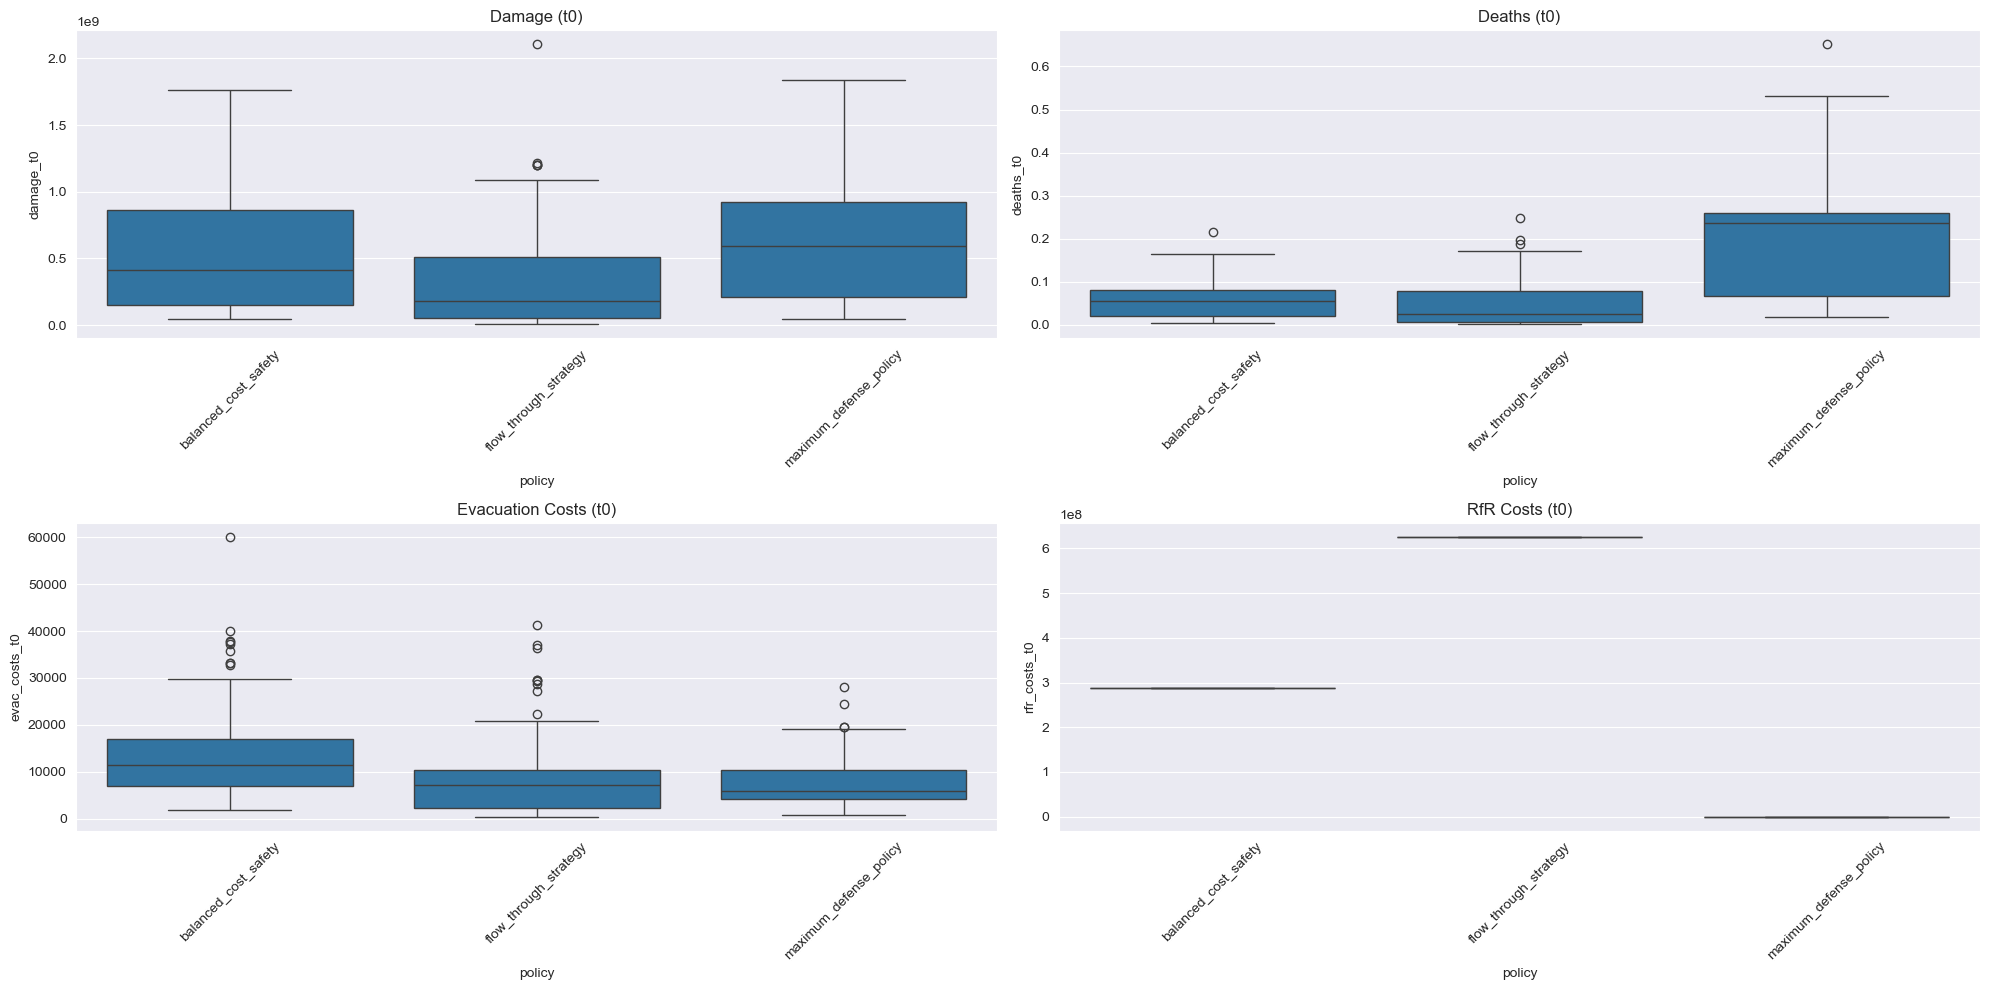

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(data=df, x="policy", y="damage_t0", ax=axes[0,0])
axes[0,0].set_title("Damage (t0)")

sns.boxplot(data=df, x="policy", y="deaths_t0", ax=axes[0,1])
axes[0,1].set_title("Deaths (t0)")

sns.boxplot(data=df, x="policy", y="evac_costs_t0", ax=axes[1,0])
axes[1,0].set_title("Evacuation Costs (t0)")

sns.boxplot(data=df, x="policy", y="rfr_costs_t0", ax=axes[1,1])
axes[1,1].set_title("RfR Costs (t0)")

for row in axes:
    for ax in row:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [10]:
#Dijkgroepen

policies = [

    # Policy A - full local protection using maximum dike heightening
    # No Room for the River; protection through infrastructure
    # Appeals to dike rings concerned with urban safety and liability
    # Conflict with ecological and groundwater goals of Veluwe
    Policy("maximum_local_protection", **dict(
        get_do_nothing_dict(),
        **{
            "1_RfR 0": 0, "2_RfR 0": 0, "3_RfR 0": 0, "4_RfR 0": 0, "5_RfR 0": 0,
            "Deventer_DikeIncrease 0": 10,
            "Zutphen_DikeIncrease 0": 10,
            "EWS_DaysToThreat": 1
        }
    )),

    # Policy B - mixed strategy: RfR where possible, moderate dike upgrades
    # Tailored for dike rings like Gorssel, Deventer that must balance safety with landscape use
    # Appeals to pragmatic local governments and communities
    Policy("adaptive_combination_policy", **dict(
        get_do_nothing_dict(),
        **{
            "1_RfR 0": 1, "2_RfR 0": 0, "3_RfR 0": 1, "4_RfR 0": 0, "5_RfR 0": 1,
            "Deventer_DikeIncrease 0": 4,
            "Zutphen_DikeIncrease 0": 3,
            "EWS_DaysToThreat": 3
        }
    )),

    # Policy C - minimal disruption to land use
    # Only uses RfR where there's no resistance; very early evacuation system
    # Ideal for more rural or agricultural dike rings like Doesburg, Cortenoever
    # Low-cost, low-impact strategy with social acceptability in mind
    Policy("minimal_disruption_policy", **dict(
        get_do_nothing_dict(),
        **{
            "1_RfR 0": 0, "2_RfR 0": 1, "3_RfR 0": 0, "4_RfR 0": 1, "5_RfR 0": 0,
            "Deventer_DikeIncrease 0": 2,
            "Zutphen_DikeIncrease 0": 1,
            "EWS_DaysToThreat": 4
        }
    ))
]

In [11]:
n_scenarios = 100
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

100%|████████████████████████████████████████| 300/300 [00:14<00:00, 20.17it/s]


In [12]:
experiments, outcomes = results

df = pd.DataFrame(experiments)

#Add damage per experiment
df["damage_t0"] = outcomes["Expected Annual Damage"][:, 0]
df["damage_t1"] = outcomes["Expected Annual Damage"][:, 1]
df["damage_t2"] = outcomes["Expected Annual Damage"][:, 2]

#Add deaths per experiment
df["deaths_t0"] = outcomes["Expected Number of Deaths"][:, 0]
df["deaths_t1"] = outcomes["Expected Number of Deaths"][:, 1]
df["deaths_t2"] = outcomes["Expected Number of Deaths"][:, 2]

#Add costs per experiment
df["evac_costs_t0"] = outcomes["Expected Evacuation Costs"][:,0]
df["evac_costs_t1"] = outcomes["Expected Evacuation Costs"][:, 1]
df["evac_costs_t2"] = outcomes["Expected Evacuation Costs"][:, 2]
df["rfr_costs_t0"] = outcomes["RfR Total Costs"][:,0]
df["rfr_costs_t1"] = outcomes["RfR Total Costs"][:, 1]
df["rfr_costs_t2"] = outcomes["RfR Total Costs"][:, 2]

df.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,damage_t2,deaths_t0,deaths_t1,deaths_t2,evac_costs_t0,evac_costs_t1,evac_costs_t2,rfr_costs_t0,rfr_costs_t1,rfr_costs_t2
0,48,69.691699,1.0,0.888740,175.045554,10.0,0.472355,335.739184,1.0,0.616720,...,2.494467e+07,0.014104,0.014104,0.014104,997.675570,997.675570,997.675570,0.0,0.0,0.0
1,50,37.051768,1.0,0.929693,323.849889,1.0,0.519182,282.443527,1.0,0.828129,...,6.605542e+07,0.031315,0.031315,0.031315,2952.348748,2952.348748,2952.348748,0.0,0.0,0.0
2,7,94.344688,10.0,0.570741,184.403807,1.5,0.667073,295.689551,1.0,0.966607,...,3.964666e+07,0.016139,0.016139,0.016139,734.746274,734.746274,734.746274,0.0,0.0,0.0
3,125,262.817459,10.0,0.014583,56.177991,1.5,0.496360,307.926267,10.0,0.225568,...,8.448223e+08,0.245639,0.245639,0.245639,5715.321807,5715.321807,5715.321807,0.0,0.0,0.0
4,109,282.041375,1.0,0.507543,98.625247,10.0,0.147650,67.676840,1.5,0.165711,...,1.192108e+09,0.460845,0.460845,0.460845,20798.410840,20798.410840,20798.410840,0.0,0.0,0.0


/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_53344/4047453008.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_53344/4047453008.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_53344/4047453008.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_53344/4047453008.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

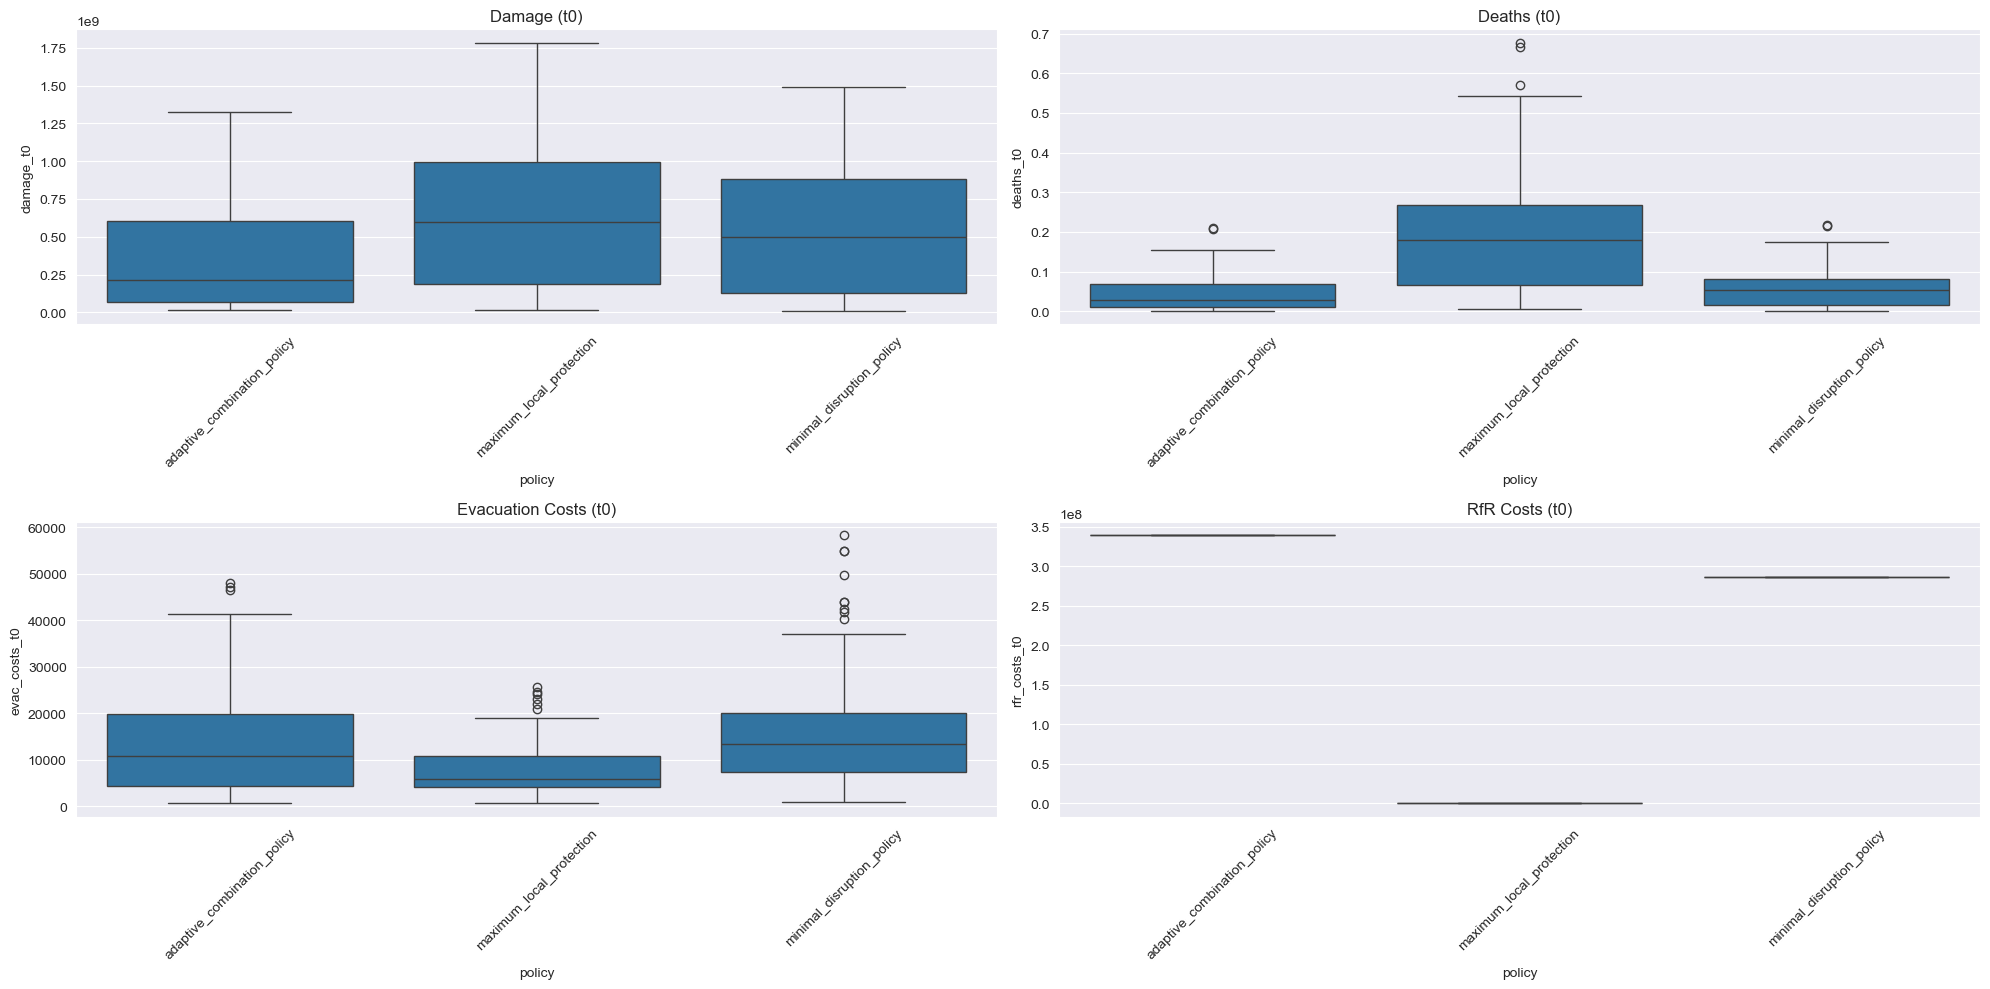

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(data=df, x="policy", y="damage_t0", ax=axes[0,0])
axes[0,0].set_title("Damage (t0)")

sns.boxplot(data=df, x="policy", y="deaths_t0", ax=axes[0,1])
axes[0,1].set_title("Deaths (t0)")

sns.boxplot(data=df, x="policy", y="evac_costs_t0", ax=axes[1,0])
axes[1,0].set_title("Evacuation Costs (t0)")

sns.boxplot(data=df, x="policy", y="rfr_costs_t0", ax=axes[1,1])
axes[1,1].set_title("RfR Costs (t0)")

for row in axes:
    for ax in row:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [14]:
policies = [

    # Policy R1 - robust infrastructure & minimal nature disruption
    # Limited use of RfR; favors controlled, affordable dike upgrades
    # Suited for a technical waterboard seeking predictable outcomes
    Policy("rijenijssel_structural_focus", **dict(
        get_do_nothing_dict(),
        **{
            "1_RfR 0": 0, "2_RfR 0": 1, "3_RfR 0": 0, "4_RfR 0": 1, "5_RfR 0": 0,
            "Deventer_DikeIncrease 0": 6,
            "Zutphen_DikeIncrease 0": 4,
            "EWS_DaysToThreat": 2
        }
    )),

    # Policy R2 - smart hybrid strategy with moderate RfR and early warning
    # Balances ecological acceptance with operational safety
    # Allows waterboard to remain adaptable and avoid community backlash
    Policy("rijenijssel_balanced_adaptive", **dict(
        get_do_nothing_dict(),
        **{
            "1_RfR 0": 1, "2_RfR 0": 1, "3_RfR 0": 1, "4_RfR 0": 0, "5_RfR 0": 0,
            "Deventer_DikeIncrease 0": 3,
            "Zutphen_DikeIncrease 0": 3,
            "EWS_DaysToThreat": 3
        }
    )),

    # Policy R3 - maximum operational flexibility and low-cost control
    # Avoids heavy investments and focuses on early response & selective RfR
    # Ideal for a board managing both rural and urban zones
    Policy("rijenijssel_minimal_cost_evasion", **dict(
        get_do_nothing_dict(),
        **{
            "1_RfR 0": 0, "2_RfR 0": 1, "3_RfR 0": 0, "4_RfR 0": 0, "5_RfR 0": 1,
            "Deventer_DikeIncrease 0": 2,
            "Zutphen_DikeIncrease 0": 1,
            "EWS_DaysToThreat": 4
        }
    ))
]


In [15]:
n_scenarios = 100
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

100%|████████████████████████████████████████| 300/300 [00:13<00:00, 21.44it/s]


In [16]:
experiments, outcomes = results

df = pd.DataFrame(experiments)

#Add damage per experiment
df["damage_t0"] = outcomes["Expected Annual Damage"][:, 0]
df["damage_t1"] = outcomes["Expected Annual Damage"][:, 1]
df["damage_t2"] = outcomes["Expected Annual Damage"][:, 2]

#Add deaths per experiment
df["deaths_t0"] = outcomes["Expected Number of Deaths"][:, 0]
df["deaths_t1"] = outcomes["Expected Number of Deaths"][:, 1]
df["deaths_t2"] = outcomes["Expected Number of Deaths"][:, 2]

#Add costs per experiment
df["evac_costs_t0"] = outcomes["Expected Evacuation Costs"][:,0]
df["evac_costs_t1"] = outcomes["Expected Evacuation Costs"][:, 1]
df["evac_costs_t2"] = outcomes["Expected Evacuation Costs"][:, 2]
df["rfr_costs_t0"] = outcomes["RfR Total Costs"][:,0]
df["rfr_costs_t1"] = outcomes["RfR Total Costs"][:, 1]
df["rfr_costs_t2"] = outcomes["RfR Total Costs"][:, 2]

df.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,damage_t2,deaths_t0,deaths_t1,deaths_t2,evac_costs_t0,evac_costs_t1,evac_costs_t2,rfr_costs_t0,rfr_costs_t1,rfr_costs_t2
0,25,307.341521,1.0,0.484961,44.968053,1.0,0.720359,241.679188,10.0,0.108615,...,3.924530e+08,0.129992,0.129992,0.129992,21306.181618,21306.181618,21306.181618,286800000.0,0.0,0.0
1,94,283.541001,10.0,0.704772,92.659159,1.5,0.303248,288.967870,1.5,0.881102,...,7.263623e+07,0.007149,0.007149,0.007149,2200.402888,2200.402888,2200.402888,286800000.0,0.0,0.0
2,64,249.313898,1.5,0.769254,335.725528,10.0,0.249460,63.324346,1.5,0.929284,...,1.829699e+08,0.023365,0.023365,0.023365,8564.791661,8564.791661,8564.791661,286800000.0,0.0,0.0
3,84,326.154929,10.0,0.755263,274.525064,1.0,0.801624,38.188425,1.5,0.516806,...,4.007860e+07,0.007294,0.007294,0.007294,1336.937613,1336.937613,1336.937613,286800000.0,0.0,0.0
4,92,139.167514,10.0,0.307111,57.151526,1.5,0.140847,127.791363,1.5,0.865361,...,7.099725e+08,0.104784,0.104784,0.104784,11788.512210,11788.512210,11788.512210,286800000.0,0.0,0.0


/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_53344/4047453008.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_53344/4047453008.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_53344/4047453008.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_53344/4047453008.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

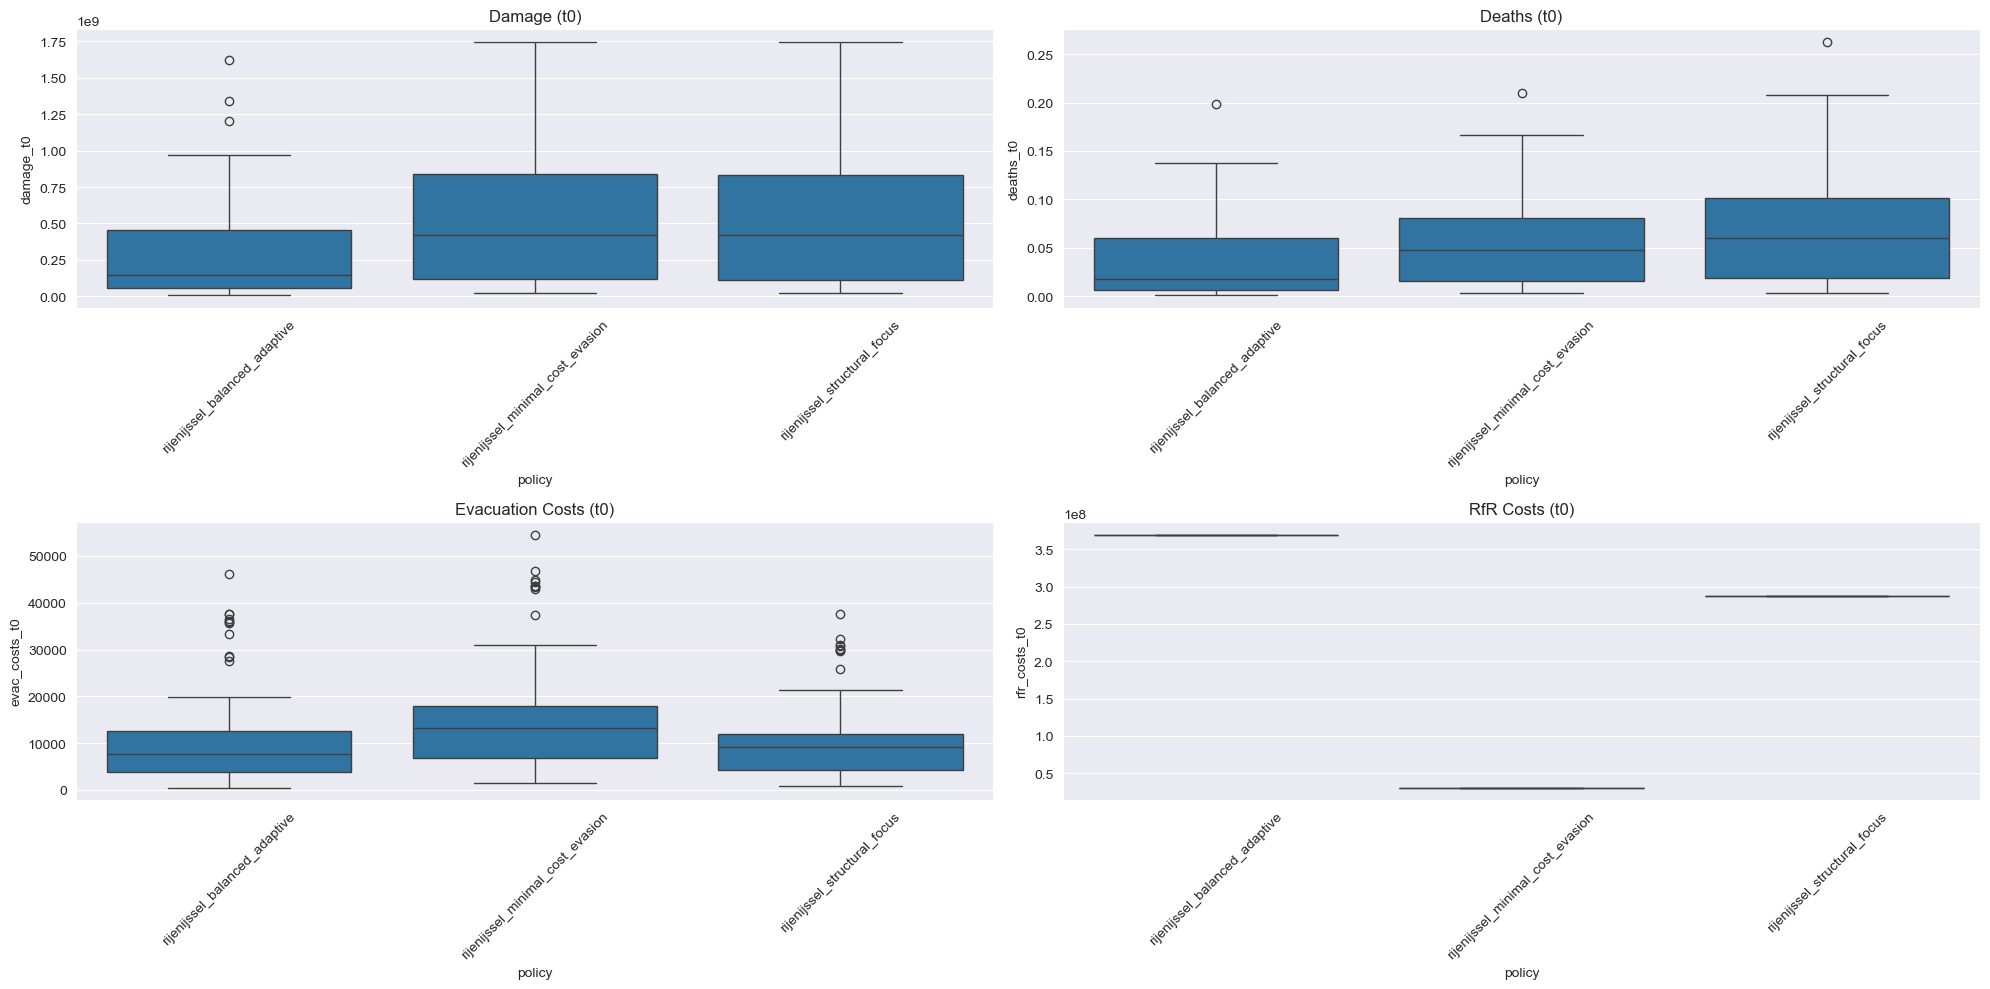

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(data=df, x="policy", y="damage_t0", ax=axes[0,0])
axes[0,0].set_title("Damage (t0)")

sns.boxplot(data=df, x="policy", y="deaths_t0", ax=axes[0,1])
axes[0,1].set_title("Deaths (t0)")

sns.boxplot(data=df, x="policy", y="evac_costs_t0", ax=axes[1,0])
axes[1,0].set_title("Evacuation Costs (t0)")

sns.boxplot(data=df, x="policy", y="rfr_costs_t0", ax=axes[1,1])
axes[1,1].set_title("RfR Costs (t0)")

for row in axes:
    for ax in row:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()